In [219]:
from extract_data import extract_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import filtfilt, butter, iirnotch
import math
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

### Creating target variable lists

In [502]:
data_train, _, starts_train, ends_train = extract_data("./SAD_train.txt","./SAD_train_times.txt")
data_test, _, starts_test, ends_test = extract_data("./bad2.txt","./bad2_times.txt")

2022-04-18T15:41:16.932-05
2022-04-25T18:43:18.403-05


In [503]:
train_len = data_train.shape[0]; test_len = data_test.shape[0]
y_tr = np.zeros(train_len)
y_te = np.zeros(test_len)

for i in range(len(starts_train)):
    start = max(starts_train[i]+100,0)
    end = ends_train[i]-100
    y_tr[start:end] = 1
for i in range(len(starts_test)):
    start = max(starts_test[i]+100,0)
    end = ends_test[i]-100
    y_te[start:end] = 1

print(np.count_nonzero(y_tr))
print(np.count_nonzero(y_te))


196914
33920


### Filtering

In [504]:
low_cutoff = 20
high_cutoff = 450

b_notch, a_notch = iirnotch(60, 30, 1000)
b, a = butter(10, [low_cutoff, high_cutoff], fs=1000, btype="bandpass")

data_train = filtfilt(b_notch, a_notch, data_train, axis=0)
data_test = filtfilt(b_notch, a_notch, data_test, axis=0)
data_train = filtfilt(b, a, data_train, axis=0)
data_test = filtfilt(b, a, data_test, axis=0)

data_train = abs(data_train); data_test = abs(data_test)


### RMS

In [453]:
def rms(data):
    rms_window = deque([0,0,0,0,0])
    rms_data = np.zeros(len(data))
    for i in range(len(data)):
        rms_window.popleft()
        rms_window.append(data[i])
        rms_data[i] = np.sqrt(np.sum(np.square(rms_window))/5)

    return rms_data

In [505]:
rms_train = np.zeros_like(data_train)
for i in range(6):
    if i in [0,1,5]:
        rms_train[:,i] = rms(data_train[:,i])

rms_test = np.zeros_like(data_test)
for i in range(6):
    if i in [0,1,5]:
        rms_test[:,i] = rms(data_test[:,i])

### Smoothing

In [455]:
skip = 20; window_length = 40
def smooth(data):
    start = 0; end = skip; i = 0
    downsampled = np.zeros(int(len(data)/skip)+1)
    smooth_window = deque([0]*window_length)

    while start < len(data):
        for k in range(skip):
            smooth_window.popleft()

        smooth_window.extend((data[start:end]).tolist())
        downsampled[i] = np.mean(smooth_window, dtype=np.float64)
        start += skip; end = min(end+skip,len(data)); i += 1

    return downsampled

In [506]:
smooth_train = np.zeros((int(train_len/skip)+1,6))
for i in range(6):
    if i in [0,1,5]:
        smooth_train[:,i] = smooth(rms_train[:,i])

smooth_test = np.zeros((int(test_len/skip)+1,6))
for i in range(6):
    if i in [0,1,5]:
        smooth_test[:, i] = smooth(rms_test[:,i])

In [507]:
start = 0; end = window_length; i=0
y_train_new = np.zeros(int(len(y_tr)/skip)+1)
y_test_new = np.zeros(int(len(y_te)/skip)+1)

while start < len(y_tr):
    if np.count_nonzero(y_tr[start:end]) > 19:
        y_train_new[i] = 1
    start += skip; end = min(end + skip, len(y_tr)); i += 1

start = 0; end = window_length; i=0
while start < len(y_te):
    if np.count_nonzero(y_te[start:end]) > 19:
        y_test_new[i] = 1
    start += skip; end = min(end + skip, len(y_te)); i += 1

### Train Decision Tree

In [518]:
df_train = pd.DataFrame({
    "Chan1": smooth_train[:,0],
    "Chan2": smooth_train[:,1],
    "Chan6": smooth_train[:,5],
    "Y": y_train_new
})

df_test = pd.DataFrame({
    "Chan1": smooth_test[:,0],
    "Chan2": smooth_test[:,1],
    "Chan6": smooth_test[:,5],
    "Y" : y_test_new
})

X_train = df_train[["Chan1","Chan2","Chan6"]]; y_train = df_train[["Y"]]
X_test = df_test[["Chan1","Chan2","Chan6"]]; y_test = df_test[["Y"]]


In [519]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)
print(accuracy_score(y_test, predicted))
print(confusion_matrix(y_test,predicted))

0.8319891167039161
[[7479 1114]
 [ 615 1083]]


### Time thresholding

In [520]:
def time_thresh(pred):
    isSpeech = False
    speech_event = np.zeros_like(pred)
    inactive_count = 0; active_count = 0
    inactive_thresh = 7; active_thresh = 3

    for i in range(len(pred)):
        if isSpeech:
            if pred[i]:
                inactive_count = 0
            else:
                inactive_count += 1
                active_count = 0

            if inactive_count > inactive_thresh:
                isSpeech = False
                speech_event[i] = 0
            else:
                speech_event[i] = 1

        else:
            if pred[i]:
                active_count += 1
                inactive_count = 0
            else:
                active_count = 0

            if active_count > active_thresh:
                isSpeech = True
                speech_event[i] = 1
            else:
                speech_event[i] = 0

    return speech_event

In [521]:
pred_final = time_thresh(predicted)
print(accuracy_score(y_test, pred_final))
print(confusion_matrix(y_test,pred_final))

0.8198425808959284
[[7203 1390]
 [ 464 1234]]


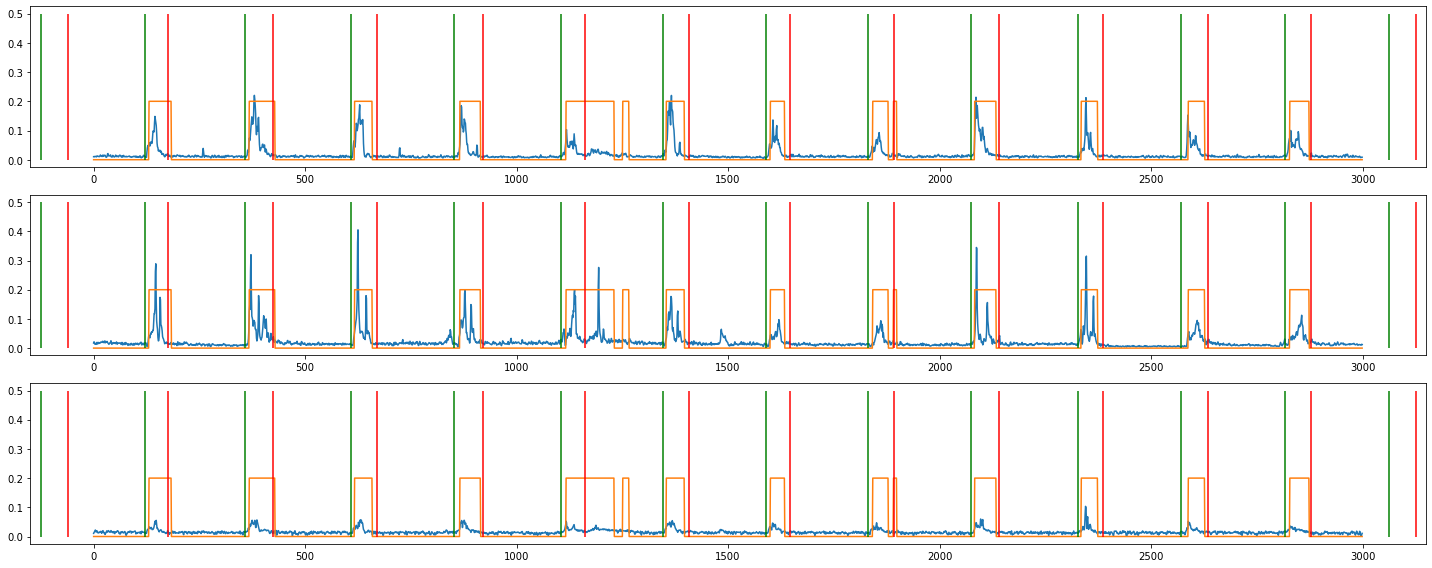

In [522]:
starts = starts_test + 100
ends = ends_test - 100
plt.figure(figsize=(20,8))
idx = [0,1,5]
start = 3000; end = 6000
for i, val in enumerate(idx):
    plt.subplot(3,1,i+1)
    plt.plot(smooth_test[start:end,val])
    plt.plot(pred_final[start:end]*.2); 
    plt.xlim(plt.xlim())
    plt.vlines(starts/20-start,0,.5,'g'); plt.vlines(ends/20-start,0,.5,'r')
plt.tight_layout()
plt.show()

In [500]:
import pickle 
with open("scaler.pkl", 'wb') as open_file:
    pickle.dump(scaler, open_file)
with open("classifier.pkl", 'wb') as open_file:
    pickle.dump(clf, open_file)